Six-Hump Camel synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 872 kB 60.3 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=b114553afd6d39b523871e5ec1e90eb34e505f9253c90f534a31d8345513aa91
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=330b23197922de629151a10f3d8b10c262affebe70765d49bc500b3c70008df8
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    y_lb = -1.0316
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    
    lb_x2 = -2
    ub_x2 = +2
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}
    
# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    
1  	 [-1.18606724 -0.3273087 ]	 2.4047696379787307	 -0.2650082867644827	 -3.078036035494468
2  	 [-0.19390412  1.86395524]	 34.17255061957859	 -0.2650082867644827	 -1.8464594046569802
3  	 [-1.45382921  0.5760335 ]	 0.49610791146089406	 -0.2650082867644827	 -1.8025127712306575
4  	 [ 3. -2.]	 150.89999999999998	 -0.2650082867644827	 -1.796827541675828
5  	 [3. 2.]	 162.89999999999998	 -0.2650082867644827	 -1.796702506538546
6  	 [-3.  2.]	 150.89999999999998	 -0.2650082867644827	 -1.7874026015377327
7  	 [-0.7210423  -0.215

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [-0.44944718  0.00412018]	 0.7231482001421817	 0.011939608840498828	 -1.9314275004914796
2  	 [3.         1.11315648]	 113.424647272369	 0.011939608840498828	 -1.796827542528041
3  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 -1.7968249121124311
4	 [-0.42736521  0.45926211]	 -0.1994638963991371	 -0.1994638963991371	 -2.2784939176518515
5  	 [-0.4504639   0.39811412]	 0.015154254798766198	 -0.1994638963991371	 -1.9183451031495729
6  	 [-3.         -0.57745596]	 109.7433163115189	 -0.1994638963991371	 -1.7

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    
1  	 [-0.17346461  0.09867864]	 0.06277973893139305	 -0.2431922946563294	 -2.189986724031687
2  	 [-0.54021522  1.28385499]	 4.5774287830539615	 -0.2431922946563294	 -1.9476413701353115
3	 [ 0.22078907 -0.76717565]	 -0.9479740504264491	 -0.9479740504264491	 -1.86855254853335
4  	 [ 0.732424   -1.32649165]	 5.967528056487563	 -0.9479740504264491	 -1.923960797728499
5  	 [ 3. -2.]	 150.89999999999998	 -0.9479740504264491	 -1.7315977234307829
6  	 [-0.08145371 -0.2730788 ]	 -0.2273543959668489	 -0.9479740504264491	 -1.8659215744424

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    
1	 [ 0.11144458 -1.10619505]	 1.0208554028173444	 1.0208554028173444	 -3.121284965958299
2  	 [-3.  2.]	 150.89999999999998	 1.0208554028173444	 -1.7700807134243528
3	 [ 0.12887649 -0.95580394]	 -0.3731904672971223	 -0.3731904672971223	 -1.8204166142920895
4  	 [-3. -2.]	 162.89999999999998	 -0.3731904672971223	 -1.7528131128962918
5  	 [-0.25741377 -0.09920887]	 0.24247966570991158	 -0.3731904672971223	 -2.161604779665978
6	 [ 0.12542018 -0.75375546]	 -1.0135573694700057	 -1.0135573694700057	 -1.7045238536567542
7	 [ 0.12484203 -0.75

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    
1  	 [0.46777833 1.31550198]	 6.450541082662784	 -0.6512780061070701	 -1.8004643421454951
2  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 -1.7565839529300529
3  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 -1.7358122589123586
4  	 [ 0.46969233 -0.23056553]	 0.474184703465176	 -0.6512780061070701	 -1.6770242833801088
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 -1.4140101566720111
6  	 [-0.11716867 -0.49038938]	 -0.6186237725336403	 -0.6512780061070701	 -1.6392342034854868
7  	 [-0.10846498 -0.47413014

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    
1  	 [0.26547547 1.08519512]	 1.39651716938633	 -0.3096187466378422	 -1.968468253572722
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 -1.7204418369668628
3  	 [-1.21989022 -2.        ]	 52.84028877277604	 -0.3096187466378422	 -1.5862809268139106
4	 [-0.03743053  0.52283301]	 -0.8084968672448021	 -0.8084968672448021	 -1.6016392368055348
5	 [-0.03761396  0.52298627]	 -0.8088340680863705	 -0.8088340680863705	 -1.6620933303790948
6	 [-0.03777754  0.52312388]	 -0.8091363050276946	 -0.8091363050276946	 -1.69212597975125

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    
1  	 [0.18555605 1.87792633]	 36.125115835818676	 -0.46481072558790276	 -1.8679892449080469
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 -1.7968275424952864
3  	 [-0.25767148  0.40880501]	 -0.40568649046575583	 -0.46481072558790276	 -1.9119190936259844
4  	 [-0.7652725   0.76664382]	 0.13337479973750932	 -0.46481072558790276	 -1.864039312560681
5  	 [0.36644931 0.21826365]	 0.39858371815896104	 -0.46481072558790276	 -1.8224013785900848
6  	 [ 2.23619511 -2.        ]	 52.69882608924716	 -

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.89741429  0.97165935]	 0.9504765779279816	 0.03190064766213015	 -1.9522144506089112
2  	 [-3.  2.]	 150.89999999999998	 0.03190064766213015	 -1.7559160412934014
3	 [-0.28587998  0.47958084]	 -0.532432999368964	 -0.532432999368964	 -1.9385316637610508
4  	 [-0.29023523  0.46026488]	 -0.4792049746798264	 -0.532432999368964	 -1.8057935141616461
5  	 [-0.29231766  0.44859018]	 -0.4474113166390759	 -0.532432999368964	 -1.7220643534426796
6  	 [ 3. -2.]	 150.89999999999998	 -0.532432999368964	 -1.6760318511194916
7  	 [-0.2768

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    
1  	 [0.20135091 1.29640467]	 4.995651459115368	 1.395407492769129	 -1.797188334362262
2  	 [ 3.         -0.22252598]	 108.04415884598006	 1.395407492769129	 -1.7964885146806886
3  	 [-1.45530652  2.        ]	 47.30804288459779	 1.395407492769129	 -1.5553014635334035
4  	 [-1.57103754 -2.        ]	 53.23376345953507	 1.395407492769129	 -0.76756984273146
5  	 [1.97008617 2.        ]	 55.31971152409345	 1.395407492769129	 -1.6932020386324889
6	 [-0.01091924 -0.13740943]	 -0.07212209186401604	 -0.07212209186401604	 -0.7682667193994562
7	 [-0

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 -1.7914691317186022
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 -1.7185440129964389
3  	 [2.55214124 0.2669997 ]	 29.488456208101837	 0.7775687473184012	 -1.7968275424928208
4	 [-1.00040626  0.62364663]	 0.6594243995503161	 0.6594243995503161	 -4.540572540404696
5  	 [-1.07424195  0.61547971]	 0.7292299291324167	 0.6594243995503161	 -2.644405719273583
6  	 [-1.08601666  0.62910347]	 0.7036269740616133	 0.6594243995503161	 -1.911060028655126
7  	 [-0.26270172  1.845007

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    
1  	 [ 1.79082158 -2.        ]	 46.64271171509026	 -0.6254688257880329	 -1.7358831233727563
2  	 [-0.42252304  2.        ]	 47.804023416309825	 -0.6254688257880329	 -1.7010649351114964
3  	 [ 0.10293831 -0.00751535]	 0.041150258723009356	 -0.6254688257880329	 -1.8500281862227193
4  	 [ 0.08701192 -0.00331995]	 0.029831104375613152	 -0.6254688257880329	 -1.5301120659391185
5  	 [ 0.07933154 -0.00120373]	 0.024989587186518426	 -0.6254688257880329	 -1.379489332673361
6  	 [7.48406258e-02 7.58606740e-05]	 0.02234430777582383	 -0.6

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    
1	 [-1.20620877  0.96371607]	 0.9738631308602099	 0.9738631308602099	 -2.182732845123725
2  	 [1.94741903 2.        ]	 55.04285512802241	 0.9738631308602099	 -1.7968181868323168
3  	 [-3. -2.]	 162.89999999999998	 0.9738631308602099	 -1.7965634986653483
4  	 [-0.16313546 -2.        ]	 48.431242571474655	 0.9738631308602099	 -1.7838341147401664
5  	 [-0.42785092  2.        ]	 47.808198252070845	 0.9738631308602099	 -1.664324465927858
6  	 [-1.22068356  0.26098004]	 1.8279769018667624	 0.9738631308602099	 -1.1089079921523954
7  	 [-

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    
1  	 [ 0.66474215 -1.56248045]	 14.422881024510184	 0.752930921147986	 -3.5450429159038053
2  	 [-3.  2.]	 150.89999999999998	 0.752930921147986	 -1.7968275413855492
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 -1.7968275222980266
4  	 [-1.32681869 -1.1815997 ]	 6.132474358637779	 0.752930921147986	 -1.7968275424952864
5	 [-0.27789632  0.58499714]	 -0.7664577487616466	 -0.7664577487616466	 -1.7418512261960626
6	 [-0.24865453  0.58791192]	 -0.8115123185655109	 -0.8115123185655109	 -1.7719117535985487
7	 [-0.23519885  0.5891109 ]	 -0.830

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 -1.7968275424952864
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 -1.7968275424952864
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 -1.7968275424952864
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 -1.7968275424952864
5  	 [ 0.10522438 -0.47086653]	 -0.6957454314714512	 -1.029299726828387	 -2.0367727506381974
6  	 [ 0.38027662 -0.58066336]	 -0.5792244162257356	 -1.029299726828387	 -1.98

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    
1  	 [-0.2458633   1.39571724]	 7.278163944674452	 2.1163170846379233	 -1.798840566769923
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 -1.7967715674705798
3  	 [-3.  2.]	 150.89999999999998	 2.1163170846379233	 -1.7752448973695771
4	 [-0.22060124 -0.56132222]	 -0.5496692304955866	 -0.5496692304955866	 -2.202151432699387
5  	 [-0.24464718 -0.54891996]	 -0.4758447401610092	 -0.5496692304955866	 -1.92893469317841
6  	 [-0.25653182 -0.5434592 ]	 -0.43882080871807816	 -0.5496692304955866	 -1.7909072236675105
7  	 [-0.26348016 -

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    
1  	 [ 3.         -0.01515769]	 108.85360813425224	 1.8632773736203017	 -1.798128181328436
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 -1.7908885323868373
3  	 [0.52099344 2.        ]	 49.97966900644081	 1.8632773736203017	 -1.7829608310601939
4  	 [-0.8550341   0.00257994]	 1.92993727478897	 1.8632773736203017	 -0.9409587035639252
5  	 [-1.03355993 -0.07999591]	 2.3401598949873113	 1.8632773736203017	 -0.16206380435217702
6  	 [ 2.29961871 -2.        ]	 55.12233124526668	 1.8632773736203017	 0.08033970539183076
7	 [-0.

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    
1  	 [-0.59254737  1.22206697]	 3.3836107625435465	 1.7722768782964888	 -2.257146187138533
2  	 [ 3. -2.]	 150.89999999999998	 1.7722768782964888	 -1.780583333937893
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 -1.6807259916834714
4  	 [-3.  2.]	 150.89999999999998	 1.7722768782964888	 -1.3449657009823073
5	 [0.20173648 0.26452491]	 -0.047609584923095194	 -0.047609584923095194	 -2.077868028962675
6  	 [0.37608799 0.28321692]	 0.3361024962351105	 -0.047609584923095194	 -1.71404320862823
7  	 [0.46584412 0.27990719]	 0.614107517

In [29]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 -1.7940725446546302
2  	 [3.         0.49952475]	 109.6495252049931	 2.062169771852028	 -0.05067048848448348
3	 [-1.0372645   0.47353814]	 1.1008670508560152	 1.1008670508560152	 -1.7951242504224858
4  	 [-3.         -0.36843274]	 109.53603178592283	 1.1008670508560152	 -1.7919961994362998
5	 [ 0.02957262 -0.06001525]	 -0.012633682564244743	 -0.012633682564244743	 -1.2782005685913602
6  	 [ 0.03266931 -0.05927882]	 -0.011676373812428123	 -0.012633682564244743	 -1.1766266216258465
7  	 [ 0.03

In [30]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    
1  	 [-0.08928201  2.        ]	 47.85318781719301	 6.578088852480828	 -1.0826568863594723
2  	 [ 1.65750135 -2.        ]	 46.73601003878244	 6.578088852480828	 -1.5897679408356138
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 0.2634515480346633
4	 [-0.31711614 -0.25359165]	 0.22107815490632685	 0.22107815490632685	 1.6627441729357166
5	 [-0.26825104 -0.23426886]	 0.13244815502673152	 0.13244815502673152	 0.3767333390860914
6	 [-0.24379718 -0.22686367]	 0.09043513142986734	 0.09043513142986734	 -0.05540095220148073
7	 [-0.22808354 

In [31]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    
1  	 [-1.17192525 -2.        ]	 52.73988863184389	 1.5037392797834441	 -1.605213815683931
2  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 -1.666057683236881
3	 [ 0.43919427 -0.31417619]	 0.20198461668924778	 0.20198461668924778	 -0.04364599546352044
4  	 [ 0.43975123 -0.31237879]	 0.2077998357315295	 0.20198461668924778	 -0.37953522083693686
5  	 [ 0.4401277 -0.3121011]	 0.20943098877715743	 0.20198461668924778	 -0.5023652586641171
6  	 [ 0.44036964 -0.31208091]	 0.21009162204331938	 0.20198461668924778	 -0.5653655111052595
7  

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    
1  	 [1.75514828 2.        ]	 53.648527753328594	 -0.2650082867644827	 -63.9697404801726
2  	 [ 3. -2.]	 150.89999999999998	 -0.2650082867644827	 -65.69206838079043
3  	 [-2.13252313  2.        ]	 49.84539385648336	 -0.2650082867644827	 -96.59516651816023
4  	 [-0.18270921 -1.76787148]	 27.02447085233575	 -0.2650082867644827	 -93.82424234297531
5  	 [ 0.94152972 -0.04595457]	 2.0761552914038433	 -0.2650082867644827	 -84.07177288235636
6  	 [3.         0.57168948]	 109.73502141968862	 -0.2650082867644827	 -78.64136906350727


In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [3. 2.]	 162.89999999999998	 0.011939608840498828	 -21.407031180308426
2  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 -88.53083564808962
3  	 [-3.  2.]	 150.89999999999998	 0.011939608840498828	 -111.31855646180483
4  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 -126.34695880723345
5  	 [-0.06206764  1.68861922]	 21.027553800221092	 0.011939608840498828	 -139.17883594872671
6  	 [1.4640718 0.044691 ]	 2.2656475372184293	 0.011939608840498828	 -123.16496533159912
7  	 [-0.72007222  0.38863663]	

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    
1  	 [ 0.38008338 -1.25015288]	 3.5787443107570645	 -0.2431922946563294	 -32.08786696597066
2  	 [ 3. -2.]	 150.89999999999998	 -0.2431922946563294	 -29.526006369612848
3  	 [-1.11085472  2.        ]	 48.142862655459076	 -0.2431922946563294	 -79.10157477138648
4  	 [-0.84347398 -2.        ]	 51.58984324340439	 -0.2431922946563294	 -75.29776050187775
5  	 [ 0.92959302 -0.10509167]	 1.9621276359241022	 -0.2431922946563294	 -72.32458297160618
6  	 [-3.  2.]	 150.89999999999998	 -0.2431922946563294	 -68.03132099360069
7  	 [-3. -2.]

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    
1  	 [-0.41809195 -2.        ]	 49.4730015668617	 2.3196402150601703	 -78.79778951382538
2  	 [-3.  2.]	 150.89999999999998	 2.3196402150601703	 -77.59430823772246
3  	 [-3. -2.]	 162.89999999999998	 2.3196402150601703	 -103.42147396799587
4  	 [0.17966772 2.        ]	 48.486280342809486	 2.3196402150601703	 -123.39348841557128
5	 [ 0.11836122 -0.02613753]	 0.04980179498277095	 0.04980179498277095	 -113.00098514955452
6  	 [-0.91904346  0.5471925 ]	 0.7392822481972309	 0.04980179498277095	 -100.33273116936267
7  	 [ 0.79871005 -0.0663

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    
1  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 -11.117567341872487
2  	 [-2.9799385  -0.05084355]	 103.47750624762797	 -0.6512780061070701	 -84.59637359516796
3  	 [2.96827128 2.        ]	 154.1436520748268	 -0.6512780061070701	 -95.04309481308104
4  	 [ 0.17277765 -2.        ]	 47.77199061739344	 -0.6512780061070701	 -109.19233376780168
5  	 [0.07320939 2.        ]	 48.16779696798631	 -0.6512780061070701	 -103.02546387538797
6  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 -91.0411290815395
7  	 [-3.  2.]	 150

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    
1  	 [0.56671871 1.92261142]	 42.03746655405615	 -0.3096187466378422	 -18.787444357122748
2  	 [-1.20714577 -2.        ]	 52.815306304013816	 -0.3096187466378422	 -27.865468359181623
3  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 -35.673355861380614
4  	 [-3.  2.]	 150.89999999999998	 -0.3096187466378422	 -81.31766662208841
5  	 [-3.         -1.13365565]	 113.76696690576068	 -0.3096187466378422	 -98.63064468551343
6  	 [1.10884635 0.04963372]	 2.4082457418902736	 -0.3096187466378422	 -96.4022219815623
7  	 [ 0.4787

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    
1  	 [-3. -2.]	 162.89999999999998	 -0.46481072558790276	 -47.433299050884145
2  	 [0.85456462 2.        ]	 51.640123210498544	 -0.46481072558790276	 -95.32507616244585
3  	 [ 3. -2.]	 150.89999999999998	 -0.46481072558790276	 -90.19070737918257
4  	 [0.30052147 0.17265375]	 0.28057284091275464	 -0.46481072558790276	 -113.54670551539611
5  	 [-1.26084118  2.        ]	 47.869242502754425	 -0.46481072558790276	 -98.40116391605544
6  	 [3. 2.]	 162.89999999999998	 -0.46481072558790276	 -93.98098551404544
7  	 [-0.491

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-1.57287692  1.65393431]	 18.478496484786024	 0.03190064766213015	 -38.758792980635626
2  	 [ 3. -2.]	 150.89999999999998	 0.03190064766213015	 -36.91729403580883
3  	 [-3.          0.16687645]	 108.29108162877047	 0.03190064766213015	 -80.21964201800564
4  	 [0.04545946 2.        ]	 48.09917619991094	 0.03190064766213015	 -87.61263654265153
5  	 [ 0.41841813 -2.        ]	 47.80088067789954	 0.03190064766213015	 -84.04818157391956
6  	 [0.997854   0.02699296]	 2.2539058463645096	 0.03190064766213015	 -75.36044058035321
7  	

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    
1  	 [3. 2.]	 162.89999999999998	 1.395407492769129	 -52.97453833912743
2  	 [ 3. -2.]	 150.89999999999998	 1.395407492769129	 -99.3329451302944
3  	 [-0.45826778  2.        ]	 47.833971030233386	 1.395407492769129	 -118.958138727858
4  	 [0.8831123 0.0625431]	 2.0400410991736173	 1.395407492769129	 -109.23974704570863
5  	 [-1.47364446 -2.        ]	 53.14404393624867	 1.395407492769129	 -101.90182726861264
6  	 [-3.  2.]	 150.89999999999998	 1.395407492769129	 -98.51710999598595
7	 [-0.45724243  0.13749309]	 0.6104810741678387	 0.6104810

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 -25.537172896930425
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 -88.27257892088302
3  	 [-0.60195475  2.        ]	 47.985623000469374	 0.7775687473184012	 -112.34671180625071
4  	 [ 3.         -0.33694877]	 107.4865760895213	 0.7775687473184012	 -108.21896807055464
5  	 [-9.55369625e-01  3.79419389e-05]	 2.154882990424843	 0.7775687473184012	 -108.79740137710877
6  	 [-3.         -0.43997123]	 109.59549958790825	 0.7775687473184012	 -100.32014240509582
7  	 [-0.529884

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    
1  	 [ 1.81317292 -2.        ]	 46.67106207453219	 -0.6254688257880329	 -62.997771047994114
2  	 [-1.0890685  2.       ]	 48.16811553759649	 -0.6254688257880329	 -61.49316470136435
3  	 [0.72440182 0.05351781]	 1.5962652674654907	 -0.6254688257880329	 -59.823144053694726
4  	 [0.81034351 2.        ]	 51.43618083574026	 -0.6254688257880329	 -52.675514116261915
5  	 [ 0.03635108 -0.95057248]	 -0.3777391606252839	 -0.6254688257880329	 -53.325688702734304
6  	 [ 3.         -0.59586013]	 106.19646242098388	 -0.6254688257880329	 -49

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    
1  	 [-0.34447102  1.57379695]	 14.535037519688759	 1.9967735906956543	 -69.18500963898805
2  	 [3. 2.]	 162.89999999999998	 1.9967735906956543	 -64.30601045284843
3  	 [-3. -2.]	 162.89999999999998	 1.9967735906956543	 -101.15921224909428
4  	 [-0.03499542 -2.        ]	 48.07488641442547	 1.9967735906956543	 -119.98811389473978
5	 [0.67103681 0.17048636]	 1.4073158859475998	 1.4073158859475998	 -111.412337682849
6	 [-0.4579038   0.01342268]	 0.7425851015066307	 0.7425851015066307	 -99.43354405710384
7  	 [0.65349808 2.        ]	 

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    
1	 [ 0.01599936 -1.07052304]	 0.6532612451698213	 0.6532612451698213	 -46.067653651075744
2  	 [-1.24857331  1.06806795]	 1.7038167421997117	 0.6532612451698213	 -41.93331017691151
3  	 [-3. -2.]	 162.89999999999998	 0.6532612451698213	 -39.00448259513831
4  	 [-3.  2.]	 150.89999999999998	 0.6532612451698213	 -84.16712349712604
5  	 [ 3. -2.]	 150.89999999999998	 0.6532612451698213	 -92.62031396804917
6  	 [-0.29080048  2.        ]	 47.741842723858944	 0.6532612451698213	 -111.78899897476244
7  	 [-0.78674754 -0.09389904]	 1.789287976387161	 0.

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    
1  	 [1.97276669 1.56900724]	 20.898605279257207	 -1.029299726828387	 -32.82611550027315
2  	 [-1.96439309 -1.66859821]	 26.46697070063422	 -1.029299726828387	 -32.15315360846204
3  	 [-3.          0.47901049]	 106.75575545202135	 -1.029299726828387	 -31.877702029775726
4  	 [3.         0.15368723]	 109.26881420705278	 -1.029299726828387	 -53.28011091194294
5  	 [0.3382837  0.16651843]	 0.3792346585647612	 -1.029299726828387	 -63.65528347896957
6  	 [-0.22954273 -2.        ]	 48.66406360774232	 -1.029299726828387	 -62.08512637862592

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    
1	 [0.09504987 0.88129959]	 -0.57403869787426	 -0.57403869787426	 -24.741159339815752
2  	 [2.07694004 2.        ]	 57.08822810561423	 -0.57403869787426	 -22.726228049298058
3  	 [-1.30589479  2.        ]	 47.75552533393545	 -0.57403869787426	 -35.114797630674154
4	 [ 0.23016731 -0.59211127]	 -0.8409343974147755	 -0.8409343974147755	 -39.781706696007475
5  	 [-0.17407123 -2.        ]	 48.46742681396687	 -0.8409343974147755	 -37.060869618865546
6  	 [ 3. -2.]	 150.89999999999998	 -0.8409343974147755	 -38.666694399801685
7  	 [ 1.530

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    
1  	 [3.         0.36513028]	 109.53320737087877	 1.8632773736203017	 -34.546580927233
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 -66.14667351140164
3  	 [0.31580478 2.        ]	 49.00998297983898	 1.8632773736203017	 -101.17907780292236
4  	 [ 3. -2.]	 150.89999999999998	 1.8632773736203017	 -94.98479996993336
5	 [0.05636579 0.01947509]	 0.012268408666006533	 0.012268408666006533	 -107.43588894649123
6  	 [-0.79915555  0.36186799]	 1.0405012242318643	 0.012268408666006533	 -94.85799614213329
7  	 [ 0.80730078 -0.09320

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    
1  	 [-0.78228944  2.        ]	 48.17324377888034	 1.7722768782964888	 -34.531178987130666
2  	 [ 3. -2.]	 150.89999999999998	 1.7722768782964888	 -40.7917135021964
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 -83.52059447473019
4  	 [ 0.15617669 -2.        ]	 47.783966737310074	 1.7722768782964888	 -107.20195697296218
5  	 [-3.  2.]	 150.89999999999998	 1.7722768782964888	 -103.31941401673183
6	 [-0.12940291 -0.09391832]	 0.043575089099104417	 0.043575089099104417	 -106.37948543146308
7  	 [0.73901665 2.        ]	 51.09053872

In [49]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 -35.77487140125375
2  	 [ 0.76754637 -2.        ]	 48.16072397955658	 2.062169771852028	 -82.62255941300322
3  	 [3.         0.03807974]	 109.00844737442829	 2.062169771852028	 -79.43815552462645
4	 [-0.73137469  0.30403888]	 1.0318406841542855	 1.0318406841542855	 -90.21543535854136
5  	 [-3.        -0.7876402]	 110.32088317252213	 1.0318406841542855	 -84.77370594669871
6  	 [3. 2.]	 162.89999999999998	 1.0318406841542855	 -87.69581146645098
7  	 [ 3. -2.]	 150.89999999999998	 1.03184068415

In [50]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    
1  	 [ 1.61911267 -2.        ]	 46.821232195289845	 6.578088852480828	 -48.79185464302441
2  	 [-0.42866702  2.        ]	 47.808847135749744	 6.578088852480828	 -50.725229049050256
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 -51.40436734932729
4	 [-0.11486601 -0.20022559]	 -0.07852112331783768	 -0.07852112331783768	 -86.31886072271946
5  	 [-3.  2.]	 150.89999999999998	 -0.07852112331783768	 -79.1208305701896
6  	 [-1.401999    0.07384691]	 2.155066481974262	 -0.07852112331783768	 -98.00169617082113
7  	 [ 3. -2.]	 150.899999999

In [51]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    
1  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 -35.02728882936374
2  	 [-1.05657835 -2.        ]	 52.42520835007441	 1.5037392797834441	 -86.2025673818544
3  	 [-3. -2.]	 162.89999999999998	 1.5037392797834441	 -79.98992210518861
4  	 [-1.1014746  2.       ]	 48.15419217772206	 1.5037392797834441	 -103.25693270259436
5  	 [ 0.72500793 -0.00690668]	 1.565540987678011	 1.5037392797834441	 -97.910487339232
6  	 [3. 2.]	 162.89999999999998	 1.5037392797834441	 -89.14168359276556
7  	 [1.79368543 0.05490158]	 2.319299616460192	 1.5

In [52]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-0.2658009358573259, -0.4324230041054587)

In [53]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(-0.18375926548093918, 0.04261840449610358)

In [54]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(-2.4814014054585907, -0.23773993035753282)

In [55]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(-4.2667122550300425, -2.203504874231067)

In [56]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-0.9667370327122197, -0.9667370327122197)

In [57]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(-1.5083259857662752, -0.3257561052987614)

In [58]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-0.567767694400235, -0.567767694400235)

In [59]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(-0.6948145686170544, -0.5506070763501968)

In [60]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(-0.0442334382153568, -1.0718106848116216)

In [61]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(-0.2313807563785099, -0.03563650029649838)

In [62]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(-0.9010790823704407, -0.9010790823704407)

In [63]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(0.6958750220451255, -4.364208876573523)

In [64]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(-2.017552288373221, -0.2544008245556553)

In [65]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(-6.074727392833108, -6.074727392833108)

In [66]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(-0.729954806981144, -1.657234157132746)

In [67]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(1.0348161634987434, -1.2246486611181637)

In [68]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-0.4028872060396779, -0.20484661732518225)

In [69]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(0.018788699166066045, -0.8032573410201177)

In [70]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(0.0030001346983022995, -0.2042284077340919)

In [71]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(0.2099242534907819, -3.5628923737635745)

In [72]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [73]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [74]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [75]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [76]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [77]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [78]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [79]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [80]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [83]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [84]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [85]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [86]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [87]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [88]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [89]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [90]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [91]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [92]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [93]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [94]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


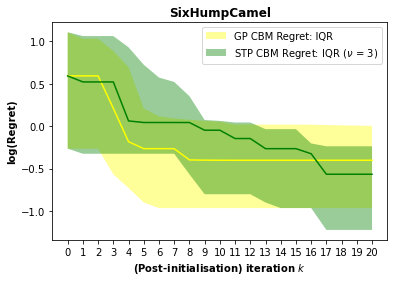

In [95]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'yellow')
plt.plot(median_stp, color = 'green')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'yellow', alpha=0.4, label='GP CBM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'green', alpha=0.4, label='STP CBM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!
